In [1]:
!df -h /dev/shm

Filesystem      Size  Used Avail Use% Mounted on
shm             5.7G     0  5.7G   0% /dev/shm


# 1. Setup

In [2]:
# Install Ultralytics library
!pip install -q ultralytics==8.0.196

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.2 MB/s eta 0:00:00


In [3]:
# Disable warnings in the notebook to maintain clean output cells
import warnings
warnings.filterwarnings('ignore')

# Import necessary libraries
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import yaml
from PIL import Image
from collections import deque
from ultralytics import YOLO
from IPython.display import Video

In [5]:
# Configure the visual appearance of Seaborn plots
sns.set(rc={'axes.facecolor': '#ffe4de'}, style='darkgrid')

#2. Load YOLOv8-seg

In [6]:
# Load the pre-trained YOLOv8 nano segmentation model
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 163MB/s]


#3. Dataset Exploration

In [7]:
# Import Dataset from Kaggle with API

# Install Kaggle library
#!pip -q install kaggle

# Download the dataset from Kaggle
#!kaggle datasets download -d rajdalsaniya/pothole-detection-dataset

# Unzip the downloaded dataset
#!unzip -q 'pothole-detection-dataset'

In [8]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="vInp1ldnZ5MKCKv2m8gV")
project = rf.workspace("school-kwzhr").project("pothole-fko0z")
version = project.version(3)
dataset = version.download("yolov8")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.6 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to POTHOLE-3 in yolov8:: 100%|██████████| 14579/14579 [00:04<00:00, 3540.35it/s]


In [9]:
# Define the dataset_path
dataset_path = '/content/POTHOLE-3'

# Set the path to the YAML file
yaml_file_path = os.path.join(dataset_path, 'data.yaml')

# Load and print the contents of the YAML file
with open(yaml_file_path, 'r') as file:
    yaml_content = yaml.load(file, Loader=yaml.FullLoader)
    print(yaml.dump(yaml_content, default_flow_style=False))

names:
- Pothole
nc: 1
roboflow:
  license: CC BY 4.0
  project: pothole-fko0z
  url: https://universe.roboflow.com/school-kwzhr/pothole-fko0z/dataset/3
  version: 3
  workspace: school-kwzhr
test: test/images
train: train/images
val: valid/images



In [10]:
# Set paths for training and validation image sets
train_images_path = os.path.join(dataset_path, 'train', 'images')
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# Initialize counters for the number of images
num_train_images = 0
num_valid_images = 0

# Initialize sets to hold the unique sizes of images
train_image_sizes = set()
valid_image_sizes = set()

# Check train images sizes and count
for filename in os.listdir(train_images_path):
    if filename.endswith('.jpg'):
        num_train_images += 1
        image_path = os.path.join(train_images_path, filename)
        with Image.open(image_path) as img:
            train_image_sizes.add(img.size)

# Check validation images sizes and count
for filename in os.listdir(valid_images_path):
    if filename.endswith('.jpg'):
        num_valid_images += 1
        image_path = os.path.join(valid_images_path, filename)
        with Image.open(image_path) as img:
            valid_image_sizes.add(img.size)

# Print the results
print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_valid_images}")

# Check if all images in training set have the same size
if len(train_image_sizes) == 1:
    print(f"All training images have the same size: {train_image_sizes.pop()}")
else:
    print("Training images have varying sizes.")

# Check if all images in validation set have the same size
if len(valid_image_sizes) == 1:
    print(f"All validation images have the same size: {valid_image_sizes.pop()}")
else:
    print("Validation images have varying sizes.")

Number of training images: 7195
Number of validation images: 90
All training images have the same size: (640, 640)
All validation images have the same size: (640, 640)


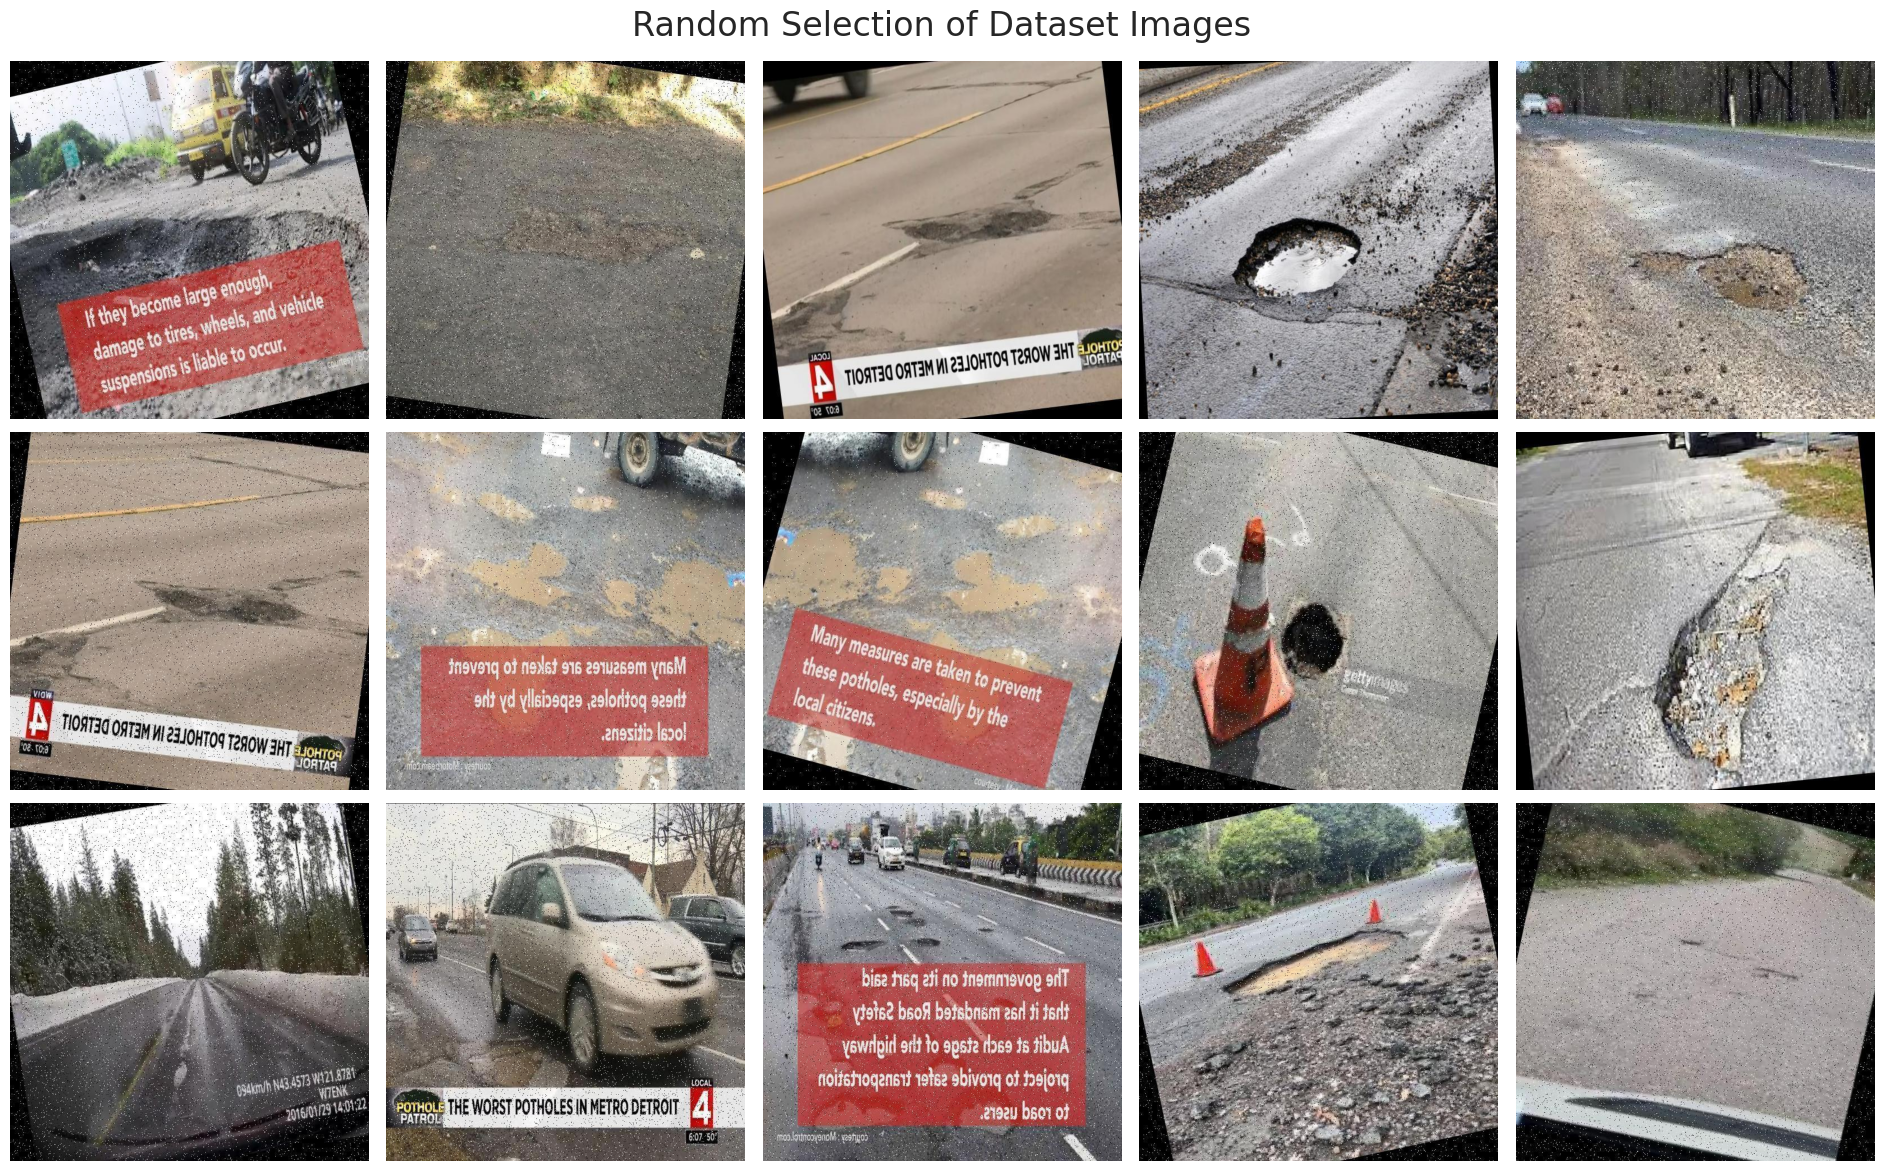

In [11]:
# Set the seed for the random number generator
random.seed(0)

# Create a list of image files
image_files = [f for f in os.listdir(train_images_path) if f.endswith('.jpg')]

# Randomly select 15 images
random_images = random.sample(image_files, 15)

# Create a new figure
plt.figure(figsize=(19, 12))

# Loop through each image and display it in a 3x5 grid
for i, image_file in enumerate(random_images):
    image_path = os.path.join(train_images_path, image_file)
    image = Image.open(image_path)
    plt.subplot(3, 5, i + 1)
    plt.imshow(image)
    plt.axis('off')

# Add a suptitle
plt.suptitle('Random Selection of Dataset Images', fontsize=24)

# Show the plot
plt.tight_layout()
plt.show()

# Deleting unnecessary variable to free up memory
del image_files

#4. Fine-Tuning YOLOv8-seg

In [ ]:
# Train the model on our custom dataset
results = model.train(
    data=yaml_file_path,     # Path to the dataset configuration file
    epochs=150,              # Number of epochs to train for
    imgsz=640,               # Size of input images as integer
    patience=20,             # Epochs to wait for no observable improvement for early stopping of training
    batch=16,                # Number of images per batch
    optimizer='Adam',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
    lr0=0.0001,              # Initial learning rate
    lrf=0.01,                # Final learning rate (lr0 * lrf)
    dropout=0.25,            # Use dropout regularization
    device=0,                # Device to run on, i.e. cuda device=0
    seed=42                  # Random seed for reproducibility
)

# Set from reference
# results = model.train(
#     data=yaml_file_path,     # Path to the dataset configuration file
#     epochs=150,              # Number of epochs to train for
#     imgsz=640,               # Size of input images as integer
#     patience=15,             # Epochs to wait for no observable improvement for early stopping of training
#     batch=16,                # Number of images per batch
#     optimizer='auto',        # Optimizer to use, choices=[SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto]
#     lr0=0.0001,              # Initial learning rate
#     lrf=0.01,                # Final learning rate (lr0 * lrf)
#     dropout=0.25,            # Use dropout regularization
#     device=0,                # Device to run on, i.e. cuda device=0
#     seed=42                  # Random seed for reproducibility
# )

New https://pypi.org/project/ultralytics/8.2.26 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/POTHOLE-3/data.yaml, epochs=150, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=Adam, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.25, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, a

#5. Evaluation

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# Define the path to the directory
post_training_files_path = '/content/runs/segment/train'

# List the files in the directory
!ls {post_training_files_path}

## 5.1 Curves Analysis

In [ ]:
# Create the full file path by joining the directory path with the filename
results_file_path = os.path.join(post_training_files_path, 'results.png')

# Read the image using cv2
image = cv2.imread(results_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(20, 8))
plt.imshow(image)
plt.title('Training and Validation Loss Trends', fontsize=24)
plt.axis('off')
plt.show()

In [ ]:
# Define a function to plot learning curves for loss values
def plot_learning_curve(df, train_loss_col, val_loss_col, title, ylim_range=[0,2]):
    plt.figure(figsize=(12, 4))
    sns.lineplot(data=df, x='epoch', y=train_loss_col, label='Train Loss', color='blue', linestyle='-', linewidth=2)
    sns.lineplot(data=df, x='epoch', y=val_loss_col, label='Validation Loss', color='#ed2f00', linestyle='--', linewidth=2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(ylim_range)
    plt.legend()
    plt.show()

In [ ]:
# Create the full file path for 'results.csv' using the directory path and file name
results_csv_path = os.path.join(post_training_files_path, 'results.csv')

# Load the CSV file from the constructed path into a pandas DataFrame
df = pd.read_csv(results_csv_path)

# Remove any leading whitespace from the column names
df.columns = df.columns.str.strip()

# Plot the learning curves for each loss
plot_learning_curve(df, 'train/box_loss', 'val/box_loss', 'Bounding Box Loss Learning Curve')
plot_learning_curve(df, 'train/cls_loss', 'val/cls_loss', 'Classification Loss Learning Curve')
plot_learning_curve(df, 'train/dfl_loss', 'val/dfl_loss', 'Distribution Focal Loss Learning Curve')
plot_learning_curve(df, 'train/seg_loss', 'val/seg_loss', 'Segmentation Loss Learning Curve', ylim_range=[0,5])

## 5.2 Confidence Threshold Metrics Analysis

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
box_files_titles = {
    'BoxP_curve.png': 'Bounding Box Precision-Confidence Curve',
    'BoxR_curve.png': 'Bounding Box Recall-Confidence Curve',
    'BoxF1_curve.png': 'Bounding Box F1-Confidence Curve'
}
mask_files_titles = {
    'MaskP_curve.png': 'Mask Precision-Confidence Curve',
    'MaskR_curve.png': 'Mask Recall-Confidence Curve',
    'MaskF1_curve.png': 'Mask F1-Confidence Curve'
}

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

# Function to read and convert image for plotting
def read_and_convert_image(file_path):
    # Read the image using cv2
    image = cv2.imread(file_path)
    # Convert from BGR to RGB
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot 'Box' images in the first column with meaningful titles
for i, (filename, title) in enumerate(box_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 0].imshow(img)
    axs[i, 0].set_title(title, fontsize=20)
    axs[i, 0].axis('off')

# Plot 'Mask' images in the second column with meaningful titles
for i, (filename, title) in enumerate(mask_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i, 1].imshow(img)
    axs[i, 1].set_title(title, fontsize=20)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

## 5.3 Precision-Recall Curve Analysis

In [ ]:
# Define the filenames for 'Box' and 'Mask' metrics along with their titles
pr_files_titles = {
    'BoxPR_curve.png': 'Bounding Box Precision-Recall Curve',
    'MaskPR_curve.png': 'Mask Precision-Recall Curve'
}

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Plot 'Box' and 'Mask' images in the subplot with meaningful titles
for i, (filename, title) in enumerate(pr_files_titles.items()):
    img_path = os.path.join(post_training_files_path, filename)
    img = read_and_convert_image(img_path)
    axs[i].imshow(img)
    axs[i].set_title(title, fontsize=20)
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## 5.4 Confusion Matrix Analysis

In [ ]:
# Construct the path to the confusion matrix images
confusion_matrix_path = os.path.join(post_training_files_path, 'confusion_matrix.png')
confusion_matrix_normalized_path = os.path.join(post_training_files_path, 'confusion_matrix_normalized.png')

# Create a 1x2 subplot
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# Read and convert both images
cm_img = read_and_convert_image(confusion_matrix_path)
cm_norm_img = read_and_convert_image(confusion_matrix_normalized_path)

# Display the images
axs[0].imshow(cm_img)
axs[0].set_title('Confusion Matrix', fontsize=24)
axs[0].axis('off')

axs[1].imshow(cm_norm_img)
axs[1].set_title('Normalized Confusion Matrix', fontsize=24)
axs[1].axis('off')

plt.tight_layout()
plt.show()

## 5.5 Validation Performance Metrics Assessment

In [ ]:
# Construct the path to the best model weights file using os.path.join
best_model_path = os.path.join(post_training_files_path, 'weights/best.pt')

# Load the best model weights into the YOLO model
best_model = YOLO(best_model_path)

# Validate the best model using the validation set with default parameters
metrics = best_model.val(split='val')

In [ ]:
# Convert the dictionary to a pandas DataFrame and use the keys as the index
metrics_df = pd.DataFrame.from_dict(metrics.results_dict, orient='index', columns=['Metric Value'])

# Display the DataFrame
metrics_df.round(3)

# 6. Model Inference

## 6.1 Inference on Validation Images

In [ ]:
# Define the path to the validation images
valid_images_path = os.path.join(dataset_path, 'valid', 'images')

# List all jpg images in the directory
image_files = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]

# Select 9 images at equal intervals
num_images = len(image_files)
selected_images = [image_files[i] for i in range(0, num_images, num_images // 9)]

# Initialize the subplot
fig, axes = plt.subplots(3, 3, figsize=(20, 21))
fig.suptitle('Validation Set Inferences', fontsize=24)

# Perform inference on each selected image and display it
for i, ax in enumerate(axes.flatten()):
    image_path = os.path.join(valid_images_path, selected_images[i])
    results = best_model.predict(source=image_path, imgsz=640)
    annotated_image = results[0].plot()
    annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    ax.imshow(annotated_image_rgb)
    ax.axis('off')

plt.tight_layout()
plt.show()